In [1]:
# conda install torch, matplotlib

%matplotlib inline


Neural Networks
===============

(https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) 참고

뉴럴네트워크는 ``torch.nn`` 패키지로 선언된다.

``nn.Module`` 은 layer를 가지고 있으며 ``forward(input)`` 메소드를 사용하여 layer를 통과시키고  ``output``을 출력한다.

아래는 간단한 feed-forward network 이다. 
입력을 받고 여러 layer를 통과하여 feature로 변하고, 마지막에 class output을 출력한다.

보통의 뉴럴네트워크의 학습은 다음을 이루어진다.:

- 학습할 수 있는 parameters (weight)를 가지고 있는 뉴럴 네트워크를 define(선언)한다.
- 데이터셋을 입력으로 구성한다. 데이터셋의 모든 데이터를 iterate한다.
- 데이터를 뉴럴네트워크에 넣기 위해 preprocess를 한다. (Normalization 등)
- 데이터를 뉴럴네트워크에 통과시키고 출력을 받는다.
- 출력을 바탕으로 loss functnion (손실 함수)를 통해 loss를 계산한다.
  - 얼마나 출력이 실제 결과에서 거리가 먼지
- gradient를 네트워크에 back propagation시킨다.
- 네트워크의 parameter를 gradient에 의해 업데이트 한다.
  - ``weight = weight - learning_rate * gradient``

네트워크 모델 선언하기
------------------

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


# forward() 

``forward`` function만 선언하면 ``backward`` function (gradients가 계산되는)은 ``autograd``를 통해 자동으로 선언됩니다.
과거에는 ``backward``도 일일히 구현해주어야 해서, 디버깅할게 더 많았었습니다.

모델에서 학습가능한 parameter들은 ``net.parameters()``로 볼수 있습니다.

In [3]:
params = list(net.parameters())
print(params[2].size())  # conv1's .weight

torch.Size([16, 6, 5, 5])


# 랜덤 32x32 input 를 통과시켜봅시다.

위에서 선언한 Net은 32x32 이미지 입력을 받는 네트워크입니다.

어떤 이미지(예를들어 MNIST)를 위의 Net에 통과시키고 싶으면 32x32으로 resize해야합니다.

In [4]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[-0.0627, -0.1090, -0.0097, -0.0920, -0.0346,  0.1949, -0.0405, -0.1113,
          0.0527, -0.0832]], grad_fn=<AddmmBackward>)


## 네트워크에 gradient들을 초기화시키고, 

In [5]:
net.zero_grad()
print(net.fc1.weight.grad)

None


## 임의의 output의 gradient를 back propagation 해줍니다.

In [6]:
out.backward(torch.randn(1, 10))
print(net.fc1.weight.grad)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0375, -0.0284, -0.0636,  ..., -0.0338, -0.0380, -0.0463],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0348,  0.0263,  0.0589,  ...,  0.0313,  0.0352,  0.0429],
        [ 0.0543,  0.0411,  0.0920,  ...,  0.0489,  0.0550,  0.0670],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


## 실제 학습하는 상황을 묘사합시다. 

input을 네트워크에 통과시키서 나온 output을

데이터 target에 맞도록 학습합시다.

In [7]:
output = net(input)
target = torch.tensor([1,0,0,0,0,0,0,0,0,0]).float()
target = target.view(1, -1)  # make it the same shape as output
print(output)
print(target)

tensor([[-0.0627, -0.1090, -0.0097, -0.0920, -0.0346,  0.1949, -0.0405, -0.1113,
          0.0527, -0.0832]], grad_fn=<AddmmBackward>)
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


## MSE loss (L2 loss)를 loss function으로 사용합시다.

In [8]:
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.1213, grad_fn=<MseLossBackward>)


## 이제 이 loss를 사용하여 네트워크를 학습해보고, 다시 한번 input을 통과시켜 학습이 반영되는지 봅시다. 

Backprop (Back Propagation, 에러 역전파)
--------
loss (error)를 역전파하기 위해 필요한건  ``loss.backward()`` 뿐입니다.
Backprop을 하기전에 ``net.zero_grad()`` 을 통해 네트워크 parameter들의 gradient를 0으로 해주어야, gradient가 누적되지 않습니다.


``loss.backward()`` 해보고, conv1의 bias값이 어떻게 되나 봅시다.

In [9]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([ 0.0055, -0.0027, -0.0002,  0.0073, -0.0064,  0.0093])


네트워크 parameter (weight) 업데이트하기
------------------
가장 간단한 업데이트 룰은 SGD, Stochastic Gradient Descent 입니다:

``weight = weight - learning_rate * gradient``

이는 다음으로 구현 가능합니다:

.. code:: python

    learning_rate = 0.01
    for f in net.parameters():
        f.data.sub_(f.grad.data * learning_rate)


다른 업데이트룰 SGD, Nesterov-SGD, Adam, RMSProp, 등은 ``torch.optim``통해서 쉽게 사용하실 수 있습니다.

In [10]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

In [11]:
output = net(input)
print(output)
print(target)

tensor([[-0.0494, -0.1062, -0.0120, -0.0909, -0.0349,  0.1895, -0.0398, -0.1096,
          0.0525, -0.0809]], grad_fn=<AddmmBackward>)
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


## 한번더!

In [12]:
# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

In [13]:
output = net(input)
print(output)
print(target)

tensor([[-0.0367, -0.1037, -0.0134, -0.0899, -0.0357,  0.1848, -0.0396, -0.1085,
          0.0530, -0.0786]], grad_fn=<AddmmBackward>)
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


## output이 점점 target에 가까워지는 것을 볼 수 있습니다!

이 작업, 즉 전체 데이터셋 (`입력`, `타겟` 값)에서 `네트워크(입력)`인 `출력`을 `타겟`에 맞추는 것을 수없이 반복하는 것이 **학습** 입니다.

방금 작업을 10번 반복해보면... 

In [14]:
for i in range(10):
    # in your training loop:
    optimizer.zero_grad()   # zero the gradient buffers
    output = net(input)
    print(output)    
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()    # Does the update

tensor([[-0.0367, -0.1037, -0.0134, -0.0899, -0.0357,  0.1848, -0.0396, -0.1085,
          0.0530, -0.0786]], grad_fn=<AddmmBackward>)
tensor([[-0.0247, -0.1013, -0.0142, -0.0888, -0.0366,  0.1809, -0.0395, -0.1078,
          0.0531, -0.0771]], grad_fn=<AddmmBackward>)
tensor([[-0.0127, -0.0991, -0.0152, -0.0879, -0.0376,  0.1774, -0.0396, -0.1071,
          0.0534, -0.0759]], grad_fn=<AddmmBackward>)
tensor([[-0.0002, -0.0975, -0.0167, -0.0870, -0.0385,  0.1741, -0.0399, -0.1062,
          0.0536, -0.0744]], grad_fn=<AddmmBackward>)
tensor([[ 0.0120, -0.0961, -0.0182, -0.0861, -0.0395,  0.1710, -0.0403, -0.1053,
          0.0538, -0.0729]], grad_fn=<AddmmBackward>)
tensor([[ 0.0234, -0.0952, -0.0200, -0.0850, -0.0400,  0.1682, -0.0402, -0.1039,
          0.0535, -0.0715]], grad_fn=<AddmmBackward>)
tensor([[ 0.0341, -0.0944, -0.0219, -0.0842, -0.0406,  0.1656, -0.0399, -0.1021,
          0.0535, -0.0705]], grad_fn=<AddmmBackward>)
tensor([[ 0.0447, -0.0936, -0.0239, -0.0836, -0.0410,  

# 방금 선언한 네트워크로 MNIST를 학습해 봅시다!

In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])


trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


# Dataset을 열어봅시다

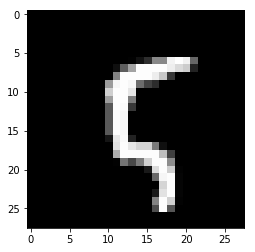

5


In [16]:
import matplotlib.pyplot as plt
i = 100
image = trainset[i][0]
label = trainset[i][1]

image.shape

# Sanity check to see an example and print its label.
example_im = image[0,:,:]
plt.imshow(example_im, cmap='gray')
plt.show()

print(label)

## 지금 성능은? .. 학습전이니까 당연히 낮아야겠죠? 약 10%로

In [17]:
net.eval()
num_correct = 0
with torch.no_grad():
    for data, target in testset:
        data = data.reshape(1,1,28,28)
        data = F.upsample(data, (32,32), mode='bilinear')
        output = net(data)
        _, output = torch.max(output, dim=1)
        num_correct += torch.sum(output == target)
print('Performance:', num_correct.item()/len(testset) * 100)        

/home/jonhpark/.local/lib/python3.6/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/jonhpark/.local/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Performance: 8.92


# Train 해봅시다!

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

net.train()

train_loss = []
train_accu = []
i = 0

for data, target in trainloader:
    data = F.upsample(data, (32,32), mode='bilinear')
    target_ = target.clone()


    optimizer.zero_grad()
    output = net(data)
    loss = criterion(output, target)
    loss.backward()    # calc gradients
    train_loss.append(loss.data)
    optimizer.step()   # update gradients


    if i % 1000 == 0:
        print('Train Step: {}\tLoss: {:.3f}'.format(i, loss.data))
    i += 1

Train Step: 0	Loss: 2.301
Train Step: 1000	Loss: 0.058
Train Step: 2000	Loss: 0.020
Train Step: 3000	Loss: 0.229
Train Step: 4000	Loss: 0.004
Train Step: 5000	Loss: 0.033
Train Step: 6000	Loss: 1.033
Train Step: 7000	Loss: 0.013
Train Step: 8000	Loss: 0.000
Train Step: 9000	Loss: 1.270
Train Step: 10000	Loss: 0.003
Train Step: 11000	Loss: 0.037
Train Step: 12000	Loss: 0.000
Train Step: 13000	Loss: 0.001
Train Step: 14000	Loss: 0.003


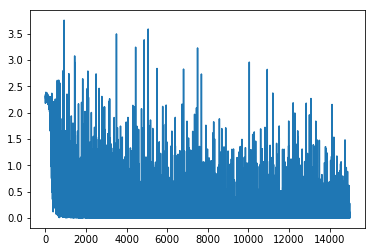

In [23]:
plt.plot(train_loss)

# Test 해봅시다!
## 일단 이미지 한개만 테스트

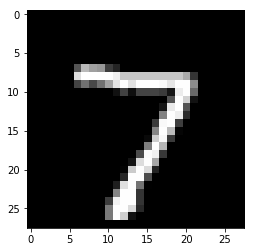

7


In [24]:
j = 0
test_image = testset[j][0]
label = testset[j][1]

# Sanity check to see an example and print its label.
example_im = test_image[0,:,:]
plt.imshow(example_im, cmap='gray')
plt.show()

print(label)

In [25]:
print(test_image.shape)

# net only accept 4D tensor
test_image = test_image.reshape(1,1,28,28)
print(test_image.shape)

torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])


In [26]:
test_image = F.upsample(test_image, (32,32), mode='bilinear')
output = net(test_image)
prediction = output.data.max(1)[1]
print('prediction is', prediction)

prediction is tensor([7])


# 전체 Testset에 해봅시다.

In [27]:
wrong = []

net.eval()
num_correct = 0
with torch.no_grad():
    for data, target in testset:
        data = data.reshape(1,1,28,28)
        data = F.upsample(data, (32,32), mode='bilinear')
        output = net(data)
        _, output = torch.max(output, dim=1)
        if torch.sum(output == target):
            num_correct += 1
        else:
            wrong.append((data,target,output))
            
print('Performance:', num_correct/len(testset) * 100)        

Performance: 98.34


# 뭘 틀렸을까요?

In [28]:
print(len(wrong))

166


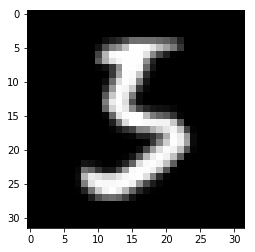

In [29]:
i = 11


# Sanity check to see an example and print its label.
example_im = wrong[i][0][0,0,:,:]
plt.imshow(example_im, cmap='gray')
plt.show()

In [30]:
print('label:',wrong[i][1], 'output:',wrong[i][2])

label: 5 output: tensor([3])


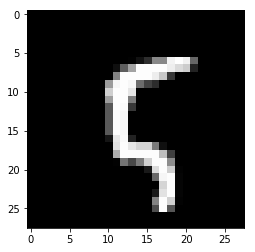

5


In [31]:
i = 100
image = trainset[i][0]
label = trainset[i][1]

image.shape

# Sanity check to see an example and print its label.
example_im = image[0,:,:]
plt.imshow(example_im, cmap='gray')
plt.show()

print(label)